### Prepare fcs files for deep learning
This is a small example for formatting data from fcs files into numpy array, and save the metaData, marker names and the numpy array into allData.obj file. Use the script as a template to prepare your own fcs files for deep learning. 

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import rpy2 as rp
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import os 
import rpy2.robjects as ro
import pickle
from collections import Counter
from pathlib import Path
import csv
import multiprocessing as mp

In [2]:
base_dir = Path('/home/kyle/a/flow/aging/data')
pickle_dir = base_dir/'ResultFiles'/'pickles'
pickle_dir.mkdir(exist_ok=True)
fcs_dir = base_dir/Path('ResultFiles/Flow_cytometry_result')

mfest_path = base_dir/Path('SDY420-DR40_Subject_2_Flow_cytometry_result.txt')
mfest = pd.read_csv(mfest_path, sep='\t')

prediction_target = 'Subject Age'

In [3]:
def fcs2pkl_filename(fcs_path):
    return pickle_dir/fcs_path.with_suffix('.pkl').name

def import_fcs(fcs_path):
    fcs_path = str(fcs_path)
    r = rp.robjects.r
    r_code = ("library(flowCore);"+
          "library(MetaCyto);"+
          "fn = '"+ fcs_path+ "'; "+
          "fcs = read.FCS(fn,truncate_max_range = FALSE);"+
          "expr = fcs@exprs;"+
          "markers = markerFinder(fcs);"+
          "colnames(expr) = markers;"+
          "expr = as.data.frame(expr);"
         )
    expr =  r(r_code)
    return pandas2ri.rpy2py(expr)

def write_dataframe(fcs_path):
    df = import_fcs(fcs_path)
    wf = fcs2pkl_filename(fcs_path)
    df.to_pickle(wf)

def load_dataframe(fcs_path):
    pkl = fcs2pkl_filename(fcs_path)
    return pd.read_pickle(pkl)

In [4]:
pkl_paths = []
to_build = []
mfest['fcs'] = mfest.apply(lambda row: fcs_dir/row['File Name'], axis=1)
mfest['pkl'] = mfest.apply(lambda row: fcs2pkl_filename(fcs_dir/row['fcs']), axis=1)
mfest['pkl_exists'] = mfest.apply(lambda row: row['pkl'].exists(), axis=1)

In [5]:
fcs_to_convert = mfest[(mfest['Expsample Treatement']=='Unstim') & ~(mfest['pkl_exists'])]['fcs']
pool = mp.Pool()
pool.map(write_dataframe, fcs_to_convert)
pool.close()
pool.terminate()
mfest['pkl_exists'] = mfest.apply(lambda row: row['pkl'].exists(), axis=1)

<AxesSubplot:ylabel='Frequency'>

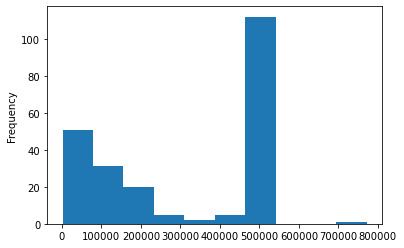

In [14]:
# expr_list = [
#     pd.read_pickle(row['pkl'])
#     for i, row in
#     mfest[mfest['Expsample Treatement']=='Unstim'].iterrows()
# ]
valid_pkls = mfest[mfest['Expsample Treatement']=='Unstim']['pkl']
shapes = [pd.read_pickle(pkl).shape[0] for pkl in valid_pkls]
pd.Series(shapes).plot.hist()

In [18]:
expr_list = [
    pd.read_pickle(row['pkl']).iloc[:1000,:]
    for i, row in
    mfest[mfest['Expsample Treatement']=='Unstim'].iterrows()
]

In [8]:
##### get common markers #####
markers = [_ for df in expr_list for _ in df.colnames]
marker_counts = Counter(markers)
markers = [k for k, c in marker_counts.items() if c == len(expr_list)]
print(markers)
sorted(marker_counts.items(), key=lambda _:_[1], reverse=True)

NameError: name 'expr_list' is not defined

In [ ]:
##### get common markers #####
markers = []
for i in range(len(expr_list)):
    markers.extend(expr_list[i].colnames)

# markers = Counter(markers)
# markers = [k for k, c in markers.items() if c == 3]
print(markers)

for i in range(0,len(expr_list)):
    t1 = expr_list[i] 
    with localconverter(ro.default_converter + pandas2ri.converter):
        t1 = ro.conversion.rpy2py(t1)
    expr_list[i] = t1.loc[:,markers]

In [ ]:
##### transform and format into numpy array
def arcsinh(x):
    return(np.arcsinh(x/5))

coln = expr_list[0].columns.drop("TIME")
for i in range(len(expr_list)):
    t1 = expr_list[i].drop(columns="TIME")
    t1 = t1.apply(arcsinh)
    t1 = t1.values
    shape1 = list(t1.shape)+[1]
    t1 = t1.reshape(shape1)
    expr_list[i] = t1
    
expr_list = np.stack(expr_list)
print("The dimenstion of the data is: ", expr_list.shape)

In [ ]:
allData = {"cytof_files":cytof_files, 
            "expr_list" : expr_list,
            "marker_names" : coln}

with open("allData.obj", "wb") as f:
    pickle.dump(allData, f)